In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genaik2025-aylin/results_clean_v2.txt
/kaggle/input/genaik2025-aylin/summary_clean_v2.txt
/kaggle/input/genaik2025-aylin/cypher_query_v2.txt
/kaggle/input/genaik2025-aylin/summary_clean.txt
/kaggle/input/genaik2025-aylin/results_clean.txt
/kaggle/input/genaik2025-aylin/cypher_query.txt
/kaggle/input/genaik2025-aylin/neo4j_query_table_data_2024-10-12.csv
/kaggle/input/genaik2025-aylin/Geoffrey_Hinton_KG.csv


# Sources:
- https://pykeen.readthedocs.io/en/stable/reference/models.html
- https://wasit7.medium.com/tutorial-knowledge-graph-embedding-with-pykeen-22d3b7847cea
- https://medium.com/@shreyash.pandey.katni/comparison-of-knowledge-graph-embeddings-kge-models-2bcd52ca3f76

# Installing Libraries and Modules

In [2]:
!pip install --upgrade --quiet pykeen
!pip install --upgrade --quiet matplotlib seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.5 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


# Importing Libraries and Modules

In [20]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
from typing import List
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pykeen.nn
import torch

# Preparing Data

In [4]:
kg_df = pd.read_csv("/kaggle/input/genaik2025-aylin/Geoffrey_Hinton_KG.csv")
kg_df.head()

,Unnamed: 0,head,head_type,relation,tail,tail_type
0,0,neural networks,invention,developed,computer vision,invention
1,1,neural networks,invention,developed,natural language processing,invention
2,2,John J. Hopfield,person,bornIn,Chicago,birthPlace
3,3,John J. Hopfield,person,worksAt,California Institute of Technology (Caltech),institution
4,4,John J. Hopfield,person,worksAt,Princeton University,institution


In [5]:
triples_factory = TriplesFactory.from_labeled_triples(
    triples=kg_df[['head', 'relation', 'tail']].values,
)

# Display the first few triples
triples_factory.triples

array([['AI applications', 'characteristics',
        'large language models like ChatGPT'],
       ['AI applications', 'characteristics', 'self-driving cars'],
       ['Geoffrey Hinton', 'advocates',
        'ethical implications of advanced technologies'],
       ['Geoffrey Hinton', 'advocates', 'responsible AI practices'],
       ['Geoffrey Hinton', 'bornAt', 'December 6, 1947'],
       ['Geoffrey Hinton', 'bornIn', 'London'],
       ['Geoffrey Hinton', 'coAuthored', 'David Rumelhart'],
       ['Geoffrey Hinton', 'coAuthored', 'Ronald J. Williams'],
       ['Geoffrey Hinton', 'coFounded', 'Vector Institute'],
       ['Geoffrey Hinton', 'collaboratedWith', 'Alex Krizhevsky'],
       ['Geoffrey Hinton', 'collaboratedWith', 'Brendan Frey'],
       ['Geoffrey Hinton', 'collaboratedWith', 'John J. Hopfield'],
       ['Geoffrey Hinton', 'collaboratedWith', 'Richard Zemel'],
       ['Geoffrey Hinton', 'collaboratedWith', 'Ruslan Salakhutdinov'],
       ['Geoffrey Hinton', 'collaboratedWith

In [6]:
training = triples_factory
validation = triples_factory
testing = triples_factory

d = training
id_to_entity = {v: k for k, v in d.entity_to_id.items()}
id_to_relation = {v: k for k, v in d.relation_to_id.items()}

for i in d.map_triples(d.triples):
    s,p,o =int(i[0]), int(i[1]), int(i[2])
    h,r,t = id_to_entity[s], id_to_relation[p], id_to_entity[o]
    print(f"{s:2d}:{h:7}{p:2d}:{r:7} {o:2d}:{t:7}")

 1:AI applications 3:characteristics 74:large language models like ChatGPT
 1:AI applications 3:characteristics 81:self-driving cars
22:Geoffrey Hinton 0:advocates 69:ethical implications of advanced technologies
22:Geoffrey Hinton 0:advocates 80:responsible AI practices
22:Geoffrey Hinton 1:bornAt  16:December 6, 1947
22:Geoffrey Hinton 2:bornIn  33:London 
22:Geoffrey Hinton 4:coAuthored 15:David Rumelhart
22:Geoffrey Hinton 4:coAuthored 43:Ronald J. Williams
22:Geoffrey Hinton 5:coFounded 55:Vector Institute
22:Geoffrey Hinton 7:collaboratedWith  3:Alex Krizhevsky
22:Geoffrey Hinton 7:collaboratedWith  7:Brendan Frey
22:Geoffrey Hinton 7:collaboratedWith 30:John J. Hopfield
22:Geoffrey Hinton 7:collaboratedWith 42:Richard Zemel
22:Geoffrey Hinton 7:collaboratedWith 45:Ruslan Salakhutdinov
22:Geoffrey Hinton 7:collaboratedWith 55:Vector Institute
22:Geoffrey Hinton 7:collaboratedWith 56:Yann LeCun
22:Geoffrey Hinton 7:collaboratedWith 57:Yoshua Bengio
22:Geoffrey Hinton 8:developed  

# Models

## TransE

Training epochs on cuda:0:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

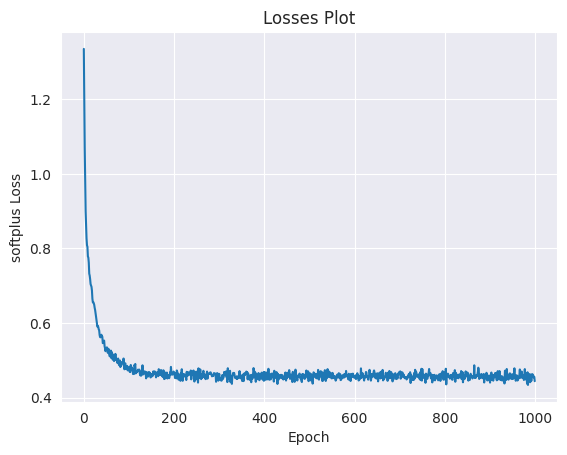

In [8]:
result_TransE = pipeline(
    model='TransE',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=1000, use_tqdm_batch=False),  # Increase the number of epochs
)

# The trained model is stored in the pipeline result
model_TransE = result_TransE.model

#plot loss
result_TransE.plot_losses()

### Visualize TransE embeddings

In [11]:
entity_representation_modules: List['pykeen.nn.Representation'] = model_TransE.entity_representations
relation_representation_modules: List['pykeen.nn.Representation'] = model_TransE.relation_representations

In [17]:
print(f"Number of relation embeddings: {relation_embeddings.shape[0]}")

Number of relation embeddings: 21


In [18]:
# Extract entity and relation embeddings
entity_embeddings = entity_representation_modules[0](indices=None).cpu().detach().numpy()  # All entity embeddings
relation_embeddings = relation_representation_modules[0](indices=None).cpu().detach().numpy()  # All relation embeddings

# Reduce dimensionality of entity embeddings
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
entity_embeddings_2d = tsne.fit_transform(entity_embeddings)

# Optionally reduce dimensionality of relation embeddings
relation_embeddings_2d = tsne.fit_transform(relation_embeddings)

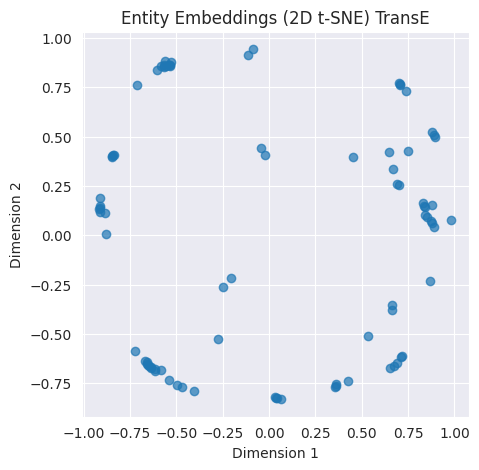

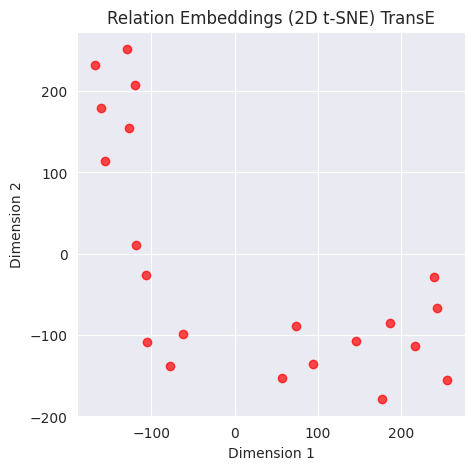

In [26]:
# Plot entity embeddings
plt.figure(figsize=(5, 5))
plt.scatter(entity_embeddings_2d[:, 0], entity_embeddings_2d[:, 1], alpha=0.7)
plt.title('Entity Embeddings (2D t-SNE) TransE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Plot relation embeddings
plt.figure(figsize=(5, 5))
plt.scatter(relation_embeddings_2d[:, 0], relation_embeddings_2d[:, 1], alpha=0.7, color='r')
plt.title('Relation Embeddings (2D t-SNE) TransE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [22]:
pca = PCA(n_components=2)
entity_embeddings_2d = pca.fit_transform(entity_embeddings)

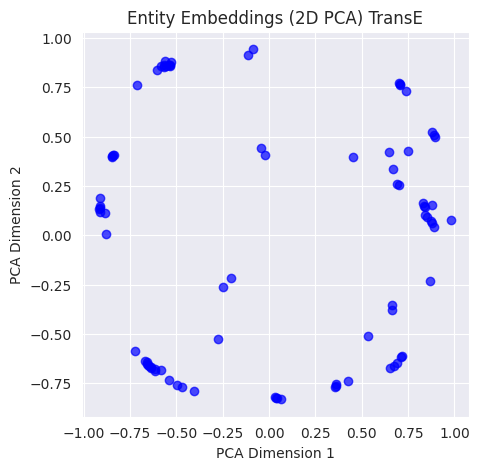

In [25]:
# Plot entity embeddings
plt.figure(figsize=(5, 5))
plt.scatter(entity_embeddings_2d[:, 0], entity_embeddings_2d[:, 1], alpha=0.7, c='blue')
plt.title('Entity Embeddings (2D PCA) TransE')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.grid(True)
plt.show()

### Computing some evaluation metrics

In [13]:
# The result object also contains the evaluation metrics result.metric_results.to_df()

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result_TransE.model,
                             testing.mapped_triples,
                             additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

Hits@1: 0.3387096774193548
Hits@3: 0.6827956989247311
Hits@5: 0.9086021505376344
Hits@10: 0.989247311827957
Mean Reciprocal Rank: 0.5523144602775574


## RotatE

Training epochs on cuda:0:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

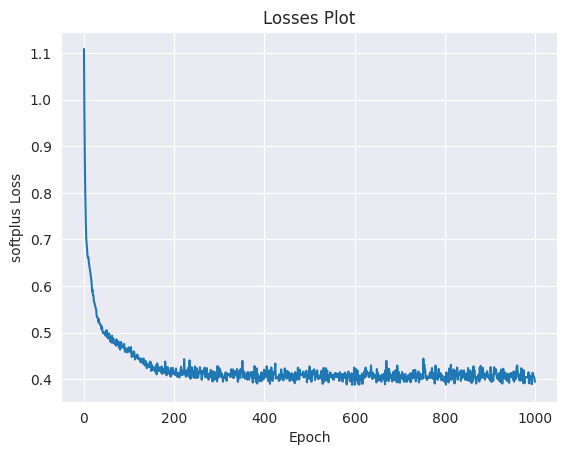

In [24]:
result_RotatE = pipeline(
    model='RotatE',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=1000, use_tqdm_batch=False),  # Increase the number of epochs
)

# The trained model is stored in the pipeline result
model_RotatE = result_RotatE.model

#plot loss
result_RotatE.plot_losses()

In [27]:
entity_representation_modules_RotatE: List['pykeen.nn.Representation'] = model_RotatE.entity_representations
relation_representation_modules_RotatE: List['pykeen.nn.Representation'] = model_RotatE.relation_representations

PCA and T-SNE could not be plotted for the embeddings of RotatE because of the complexity of embeddings.

In [28]:
# Extract entity and relation embeddings
entity_embeddings_RotatE = entity_representation_modules_RotatE[0](indices=None).cpu().detach().numpy()  
relation_embeddings_RotatE = relation_representation_modules_RotatE[0](indices=None).cpu().detach().numpy()  

In [29]:
print(f"Number of relation embeddings: {relation_embeddings_RotatE.shape[0]}")

Number of relation embeddings: 21


In [32]:
result_RotatE.metric_results.to_df()

,Side,Rank_type,Metric,Value
0,head,optimistic,adjusted_geometric_mean_rank_index,0.988112
1,tail,optimistic,adjusted_geometric_mean_rank_index,0.991331
2,both,optimistic,adjusted_geometric_mean_rank_index,0.989712
3,head,realistic,adjusted_geometric_mean_rank_index,0.988112
4,tail,realistic,adjusted_geometric_mean_rank_index,0.991331
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,1.000000
221,both,realistic,adjusted_hits_at_k,0.993885
222,head,pessimistic,adjusted_hits_at_k,0.987792
223,tail,pessimistic,adjusted_hits_at_k,1.000000


In [33]:
evaluator = RankBasedEvaluator()

metrics = evaluator.evaluate(result_RotatE.model,
                             testing.mapped_triples,
                             additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

Hits@1: 0.7419354838709677
Hits@3: 0.9139784946236559
Hits@5: 0.978494623655914
Hits@10: 0.9946236559139785
Mean Reciprocal Rank: 0.8407471179962158


## SE

In [ ]:
result_SE = pipeline(
    model='SE',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=1000, use_tqdm_batch=False),  # Increase the number of epochs
)

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

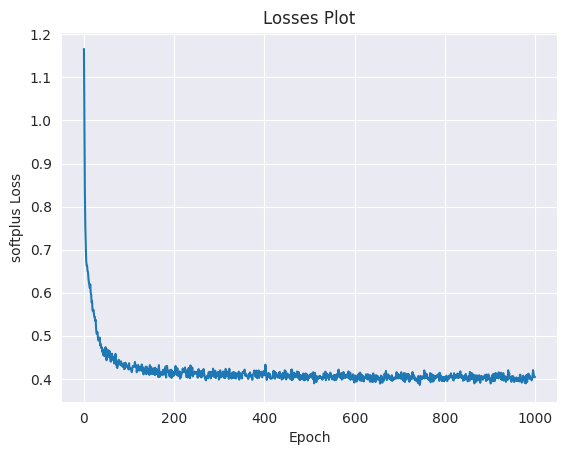

In [40]:
# The trained model is stored in the pipeline result
model_SE = result_SE.model

#plot loss
result_SE.plot_losses()

In [41]:
entity_representation_modules_SE: List['pykeen.nn.Representation'] = model_SE.entity_representations
relation_representation_modules_SE: List['pykeen.nn.Representation'] = model_SE.relation_representations

In [42]:
entity_embeddings_SE = entity_representation_modules_SE[0](indices=None).cpu().detach().numpy()  
relation_embeddings_SE = relation_representation_modules_SE[0](indices=None).cpu().detach().numpy()  

In [43]:
print(f"Number of relation embeddings: {relation_embeddings_SE.shape[0]}")

Number of relation embeddings: 21


In [44]:
evaluator = RankBasedEvaluator()

metrics = evaluator.evaluate(result_SE.model,
                             testing.mapped_triples,
                             additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

Hits@1: 0.6720430107526881
Hits@3: 0.9731182795698925
Hits@5: 1.0
Hits@10: 1.0
Mean Reciprocal Rank: 0.8257169127464294


## DistMult

Training epochs on cuda:0:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

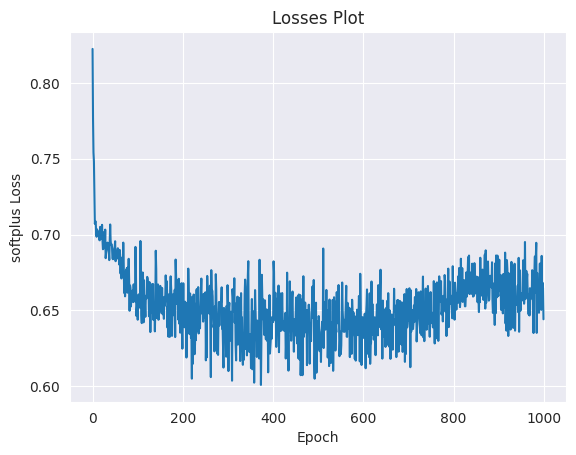

In [45]:
result_DistMult = pipeline(
    model='DistMult',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=1000, use_tqdm_batch=False),  # Increase the number of epochs
)

# The trained model is stored in the pipeline result
model_DistMult = result_DistMult.model

#plot loss
result_DistMult.plot_losses()

In [46]:
entity_representation_modules_DistMult: List['pykeen.nn.Representation'] = model_DistMult.entity_representations
relation_representation_modules_DistMult: List['pykeen.nn.Representation'] = model_DistMult.relation_representations

In [47]:
entity_embeddings_DistMult = entity_representation_modules_DistMult[0](indices=None).cpu().detach().numpy()  
relation_embeddings_DistMult = relation_representation_modules_DistMult[0](indices=None).cpu().detach().numpy()  

In [48]:
print(f"Number of relation embeddings: {relation_embeddings_DistMult.shape[0]}")

Number of relation embeddings: 21


In [49]:
evaluator = RankBasedEvaluator()

metrics = evaluator.evaluate(result_DistMult.model,
                             testing.mapped_triples,
                             additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

Hits@1: 0.03225806451612903
Hits@3: 0.478494623655914
Hits@5: 0.5
Hits@10: 0.5752688172043011
Mean Reciprocal Rank: 0.3207639157772064


## CompleX

Training epochs on cuda:0:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

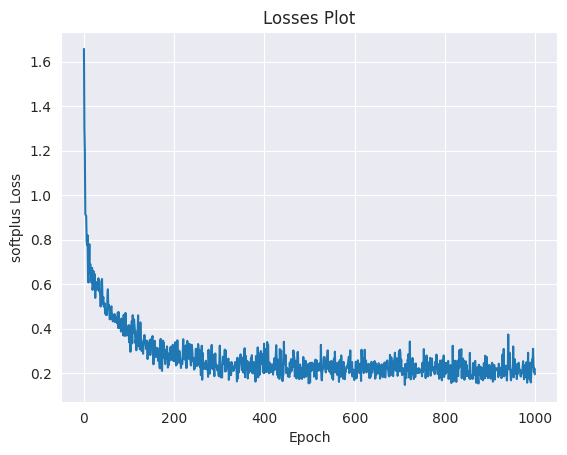

In [50]:
result_ComplEx = pipeline(
    model='ComplEx',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=1000, use_tqdm_batch=False),  # Increase the number of epochs
)

# The trained model is stored in the pipeline result
model_ComplEx = result_ComplEx.model

#plot loss
result_ComplEx.plot_losses()

In [51]:
evaluator = RankBasedEvaluator()

metrics = evaluator.evaluate(result_ComplEx.model,
                             testing.mapped_triples,
                             additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

Hits@1: 0.7956989247311828
Hits@3: 0.978494623655914
Hits@5: 1.0
Hits@10: 1.0
Mean Reciprocal Rank: 0.8862903714179993


## RGCN

In [ ]:
result_RGCN = pipeline(
    model='RGCN',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=1000, use_tqdm_batch=False),  # Increase the number of epochs
)



<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

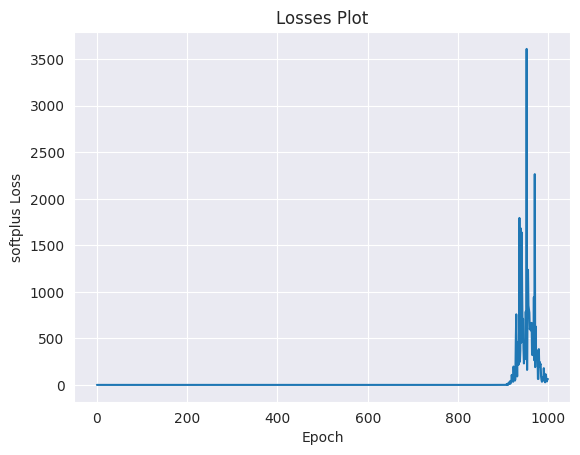

In [61]:
# The trained model is stored in the pipeline result
model_RGCN = result_RGCN.model

#plot loss
result_RGCN.plot_losses()

In [62]:
evaluator = RankBasedEvaluator()

metrics = evaluator.evaluate(result_RGCN.model,
                             testing.mapped_triples,
                             additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/93.0 [00:00<?, ?triple/s]

Hits@1: 0.016129032258064516
Hits@3: 0.05913978494623656
Hits@5: 0.11290322580645161
Hits@10: 0.3172043010752688
Mean Reciprocal Rank: 0.09552431851625443
